<a href="https://colab.research.google.com/github/darinaksena/hpc/blob/main/cuda_0_aksenova_d_33.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задача:** реализовать алгоритм перемножения матриц

**Язык:** C++ или Python

**Входные данные:** 2 матрицы размером от 100х100 до 2000х2000.

**Выходные данные:** проверка корректности перемножения + время вычисления

Реализация должна содержать 2 функции перемножения матриц: на CPU и на GPU с применением CUDA.

Отчет о проделанной лабораторной работе - это git-репозиторий с исходным кодом реализации + описание проделанной работы там же в readme.
Необходимо описать реализацию, объяснив, что конкретно было распараллелено и почему. 
Провести эксперименты: перемножить матрицы разных размеров, посчитать ускорение. Результаты привести в виде таблицы.

In [2]:
!nvidia-smi

Wed Oct 21 09:06:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from __future__ import division
from numba import cuda, float32
import time
import numpy as np
import math

#threads per block
TPB = 32
size = 100



@cuda.jit
def mult_gpu_shared(A, B, C):
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)
    
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    if x >= C.shape[0] and y >= C.shape[1]:
        return

    tmp = 0.
    for i in range(int(A.shape[1] / TPB)):
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        cuda.syncthreads()

        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        cuda.syncthreads()

    C[x, y] = tmp

def mult_cpu_np(A,B):
  return np.dot(A,B)

def mult_cpu(A, B, size):
    C = np.zeros((size,size))
    for i in range(size):
        for j in range(size):
            for k in range(size):
                C[i, j] += A[i, k] * B[k, j]
    return C
  
# A = np.full((size, size), 3, np.float)
# B = np.full((size, size), 4, np.float)
# A =np.array([[1.,2],
#              [2,1]])
# B = A
def experiment_shared(n, size):
  g_time = 0.
  c_time = 0.
  # n = 3

  for _ in range(n):
    A = np.random.randint(5, size=(size, size))
    A = A.astype(np.float64)
    B = np.random.randint(10, size=(size, size))
    B = B.astype(np.float64)

    # start = time.time()

    A_global_mem = cuda.to_device(A)
    B_global_mem = cuda.to_device(B)
    C_global_mem = cuda.device_array((size, size))

    threadsperblock = (TPB, TPB)
    blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[1]))
    blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[0]))
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    start = time.time()

    mult_gpu_shared[blockspergrid, threadsperblock](A_global_mem, B_global_mem, C_global_mem)

    g_time += time.time() - start

    C_g = C_global_mem.copy_to_host()

    # g_time += time.time() - start

    start = time.time()
    C_c = mult_cpu_np(A,B)
    c_time += time.time() - start

  print('size', size)
  print('CPU:',c_time/n)
  print('GPU:',g_time/n)
  print('speedup',c_time/g_time )
  return c_time/g_time

In [3]:
from numba import cuda, float32
import time
import numpy as np
import math

@cuda.jit
def mult_gpu_device(A, B, C):
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp


def experiment_device(n, size):
  g_time = 0.
  c_time = 0.
  # n = 3

  for _ in range(n):
    A = np.random.randint(5, size=(size, size))
    A = A.astype(np.float64)
    B = np.random.randint(10, size=(size, size))
    B = B.astype(np.float64)
    C = np.zeros((size, size))

    # start = time.time()

    A_global_mem = cuda.to_device(A)
    B_global_mem = cuda.to_device(B)
    C_global_mem = cuda.device_array((size, size))
    
    
    threadsperblock = (TPB, TPB)
    blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[1]))
    blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[0]))
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    start = time.time()

    mult_gpu_device[blockspergrid, threadsperblock](A_global_mem, B_global_mem, C_global_mem)

    g_time += time.time() - start

    C_g = C_global_mem.copy_to_host()

    

    start = time.time()
    # C_c = multiplicationCPU(A,B,size)
    C_c = mult_cpu_np(A,B)

    c_time += time.time() - start

  print('size', size)
  print('CPU:',c_time/n)
  print('GPU:',g_time/n)
  print('speedup',c_time/g_time )
  return c_time/g_time

In [4]:
res = np.zeros((5,2), dtype = np.float64)

res[0][0], res[0][1] = 128, experiment_device(5,128)
res[1][0], res[1][1] = 256, experiment_device(5,256)
res[2][0], res[2][1] = 512, experiment_device(5,512)
res[3][0], res[3][1] = 1024, experiment_device(5,1024)
res[4][0], res[4][1] = 2048, experiment_device(5,2048)

size 128
CPU: 0.0011011600494384766
GPU: 0.10027532577514649
speedup 0.010981365963424295
size 256
CPU: 0.0011209964752197266
GPU: 0.0004054069519042969
speedup 2.765114090802164
size 512
CPU: 0.007796430587768554
GPU: 0.0005513191223144531
speedup 14.141411520498183
size 1024
CPU: 0.05426249504089355
GPU: 0.0005418777465820313
speedup 100.1378915874692
size 2048
CPU: 0.4198801517486572
GPU: 0.0004189014434814453
speedup 1002.3363688104724


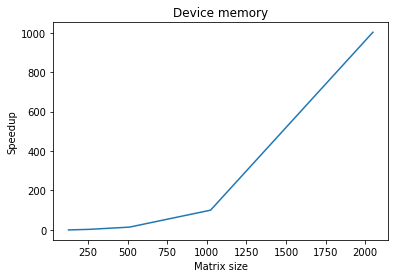

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
# print(res)
plt.plot(res[:,0], res[:,1]) 
plt.xlabel('Matrix size')
plt.ylabel('Speedup')
plt.title('Device memory')
plt.show()

In [6]:
res = np.zeros((5,2), dtype = np.float64)

res[0][0], res[0][1] = 128, experiment_shared(5,128)
res[1][0], res[1][1] = 256, experiment_shared(5,256)
res[2][0], res[2][1] = 512, experiment_shared(5,512)
res[3][0], res[3][1] = 1024, experiment_shared(5,1024)
res[4][0], res[4][1] = 2048, experiment_shared(5,2048)

size 128
CPU: 0.00021138191223144532
GPU: 0.049320316314697264
speedup 0.004285899362094203
size 256
CPU: 0.001058483123779297
GPU: 0.00041513442993164064
speedup 2.549735814380887
size 512
CPU: 0.007463932037353516
GPU: 0.0005510330200195312
speedup 13.545344409830392
size 1024
CPU: 0.05610599517822266
GPU: 0.000550222396850586
speedup 101.96966808215616
size 2048
CPU: 0.4105886459350586
GPU: 0.0004082202911376953
speedup 1005.8016586847331


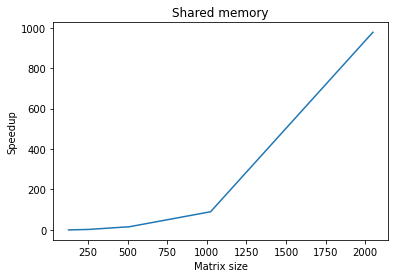

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
# print(res)
plt.plot(res[:,0], res[:,1]) 
plt.xlabel('Matrix size')
plt.ylabel('Speedup')
plt.title('Shared memory')
plt.show()

In [8]:
g_time = 0.
c_time = 0.
n = 3

for _ in range(n):
  A = np.random.randint(5, size=(size, size))
  A = A.astype(np.float64)
  B = np.random.randint(10, size=(size, size))
  B = B.astype(np.float64)

  start = time.time()

  A_global_mem = cuda.to_device(A)
  B_global_mem = cuda.to_device(B)
  C_global_mem = cuda.device_array((size, size))

  threadsperblock = (TPB, TPB)
  blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[1]))
  blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[0]))
  blockspergrid = (blockspergrid_x, blockspergrid_y)

  mult_gpu_global[blockspergrid, threadsperblock](A_global_mem, B_global_mem, C_global_mem)
  C_g = C_global_mem.copy_to_host()

  g_time += time.time() - start

  start = time.time()
  C_c = mult_cpu_np(A,B)

  c_time += time.time() - start

print('size', size)
print('CPU:',c_time/n)
print('GPU:',g_time/n)

size 100
CPU: 0.002389828364054362
GPU: 0.003298044204711914
